#BERT 기반 단일 문장 분류 모델 학습


In [1]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230710")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230710'

라이브러리

In [ ]:
!pip install transformers datasets wandb accelerate

In [3]:
import os
import pandas as pd
import re
import numpy as np
import os
import keras
import urllib.request
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import sys
from accelerate import Accelerator


import random
import logging
from IPython.display import display, HTML
import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoModel, AutoTokenizer, BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

Data
>데이터증강: Origin Data + RS(40%) + RD(35%)

In [4]:
#원데이터
df_org = pd.read_csv('train.csv')

#data shuffle
df = df_org.sample(frac=1)

def preprocess_sentence(sentence):

    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

def check_class(it):
    if '협박' in it:
        return 0
    elif '갈취' in it:
        return 1
    elif '직장 내 괴롭힘' in it:
        return 2
    elif '기타 괴롭힘' in it:
        return 3
    else:
        return 4

df['data'] = df['conversation'].apply(lambda it : preprocess_sentence(it))
df['label'] = df['class'].apply(lambda it: check_class(it))

df = df[['data', 'label']]

print(len(df))

#원데이터 이용해서 train & test분류
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
print(len(train_data))
print(len(test_data))

3950
3555
395


In [5]:
#증강데이터 로드
df_rs = pd.read_csv('train_rs.csv')
df_rd = pd.read_csv('train_rd.csv')

print(len(df_rs))
print(len(df_rd))

ratio_rs = 0.4
df_rs = df_rs.sample(frac=ratio_rs)

ratio_rd = 0.35
df_rd = df_rd.sample(frac=ratio_rd)

print(len(df_rs))
print(len(df_rd))

3950
3950
1580
1382


In [6]:
print(len(train_data))
train_data.head(3)

3555


,data,label
1521,와 이봐 . 엄청 먹는다 . 그러게 . 왜저렇게 많이 먹어 . 저렇게 먹으니깐 관리...,3
2635,손이 왜그러세요 ? 아 조금 다쳤어요 아 그러시구나 우리애가 놀래서요 안보이게 주머...,3
3651,야 너 뭐야 ? 저요 ? 저 아세요 ? 온라인으로 병신같은 짓 하고 돌아다니면 다야...,3


In [7]:
df_rs = df_rs[['data', 'label']]
df_rs.head(3)

,data,label
1981,이리 그건 요즘 소문이 ? 안나게 해볼까요 시대에도 것 있어요 진짜 ? 겠어요 거깄...,2
2830,. 재밌는 놀이를 하는 해줄 . 진우야 . 어 마시면 새도 그 니가 오늘 내 시험지...,0
2393,확 때릴거야 진짜 생활 잘 할 안 있을 싫다면 ! ? 이러지마 ! ! 진짜 경찰에 ...,0


In [8]:
df_rd = df_rd[['data', 'label']]
df_rd.head(3)

,data,label
1983,헤어지자고 ? 장난해 헤어지고 미안해 나 못 정말 ? 싶어 이런 지금까지 내가 이 ...,0
1109,살고싶지 뭘했다고요 너에게 독약을 웃기지마 먹일거야 이거나 까지 있어 몰라 ? 니가...,0
2211,? 네 전화좀 방금 통화했어 ? 앉아있는거아니야 진짜 . 한거 맞아 말이야 숨겨둔 ...,2


In [9]:
#데이터합치기: 원본데이터 + 증강데이터
df = pd.concat([train_data, df_rs, df_rd], axis=0, ignore_index=True)

print(len(df))
df.head(3)

6517


,data,label
0,와 이봐 . 엄청 먹는다 . 그러게 . 왜저렇게 많이 먹어 . 저렇게 먹으니깐 관리...,3
1,손이 왜그러세요 ? 아 조금 다쳤어요 아 그러시구나 우리애가 놀래서요 안보이게 주머...,3
2,야 너 뭐야 ? 저요 ? 저 아세요 ? 온라인으로 병신같은 짓 하고 돌아다니면 다야...,3


학습 문장 최대 길이 : 909
학습 문장의 평균 길이 : 226.1226024244284


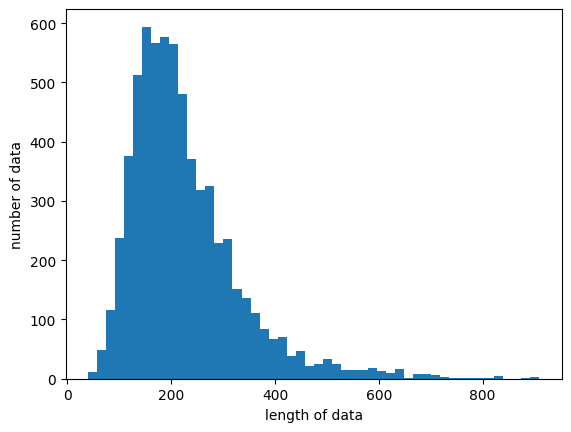

In [10]:
#데이터
print('학습 문장 최대 길이 :',max(len(l) for l in df['data']))
print('학습 문장의 평균 길이 :',sum(map(len, df['data']))/len(df['data']))

plt.hist([len(s) for s in df['data']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [11]:
train_data, valid_data = train_test_split(df, test_size=0.1, random_state=42)

print(len(train_data))
print(len(test_data))
print(len(valid_data))

5865
395
652


Fine-tuning

In [12]:
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
tokenized_train_sentences = tokenizer(
    list(train_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

tokenized_test_sentences = tokenizer(
    list(test_data['data']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

In [14]:
train_label = train_data['label'].values
test_label = test_data['label'].values

print(train_label[0])
print(test_label[0])

0
1


In [15]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)

In [ ]:
train_dataset[0]

In [16]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_steps=500,
    save_total_limit=2
)

num_labels = 4

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = num_labels)
model.to("cuda")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
)

trainer.train()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-15-d0b76757ee46>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,0.933200
1000,0.664000
1500,0.543400
2000,0.410700
2500,0.359600
3000,0.302100
3500,0.226000
4000,0.166800
4500,0.133800
5000,0.083600


<ipython-input-15-d0b76757ee46>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-d0b76757ee46>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-d0b76757ee46>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-15-d0b76757ee46>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=7340, training_loss=0.27523552487916453, metrics={'train_runtime': 6218.4025, 'train_samples_per_second': 9.432, 'train_steps_per_second': 1.18, 'total_flos': 1.54317405026304e+16, 'train_loss': 0.27523552487916453, 'epoch': 10.0})

성능평가

In [19]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

trainer.evaluate(eval_dataset=test_dataset)

<ipython-input-15-d0b76757ee46>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Trainer is attempting to log a value of "[0.93567251 0.95238095 0.95566502 0.93203883]" of type <class 'numpy.ndarray'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.91954023 0.96153846 0.94174757 0.95049505]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.95238095 0.94339623 0.97       0.91428571]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.40634992718696594,
 'eval_accuracy': 0.9443037974683545,
 'eval_f1': array([0.93567251, 0.95238095, 0.95566502, 0.93203883]),
 'eval_precision': array([0.91954023, 0.96153846, 0.94174757, 0.95049505]),
 'eval_recall': array([0.95238095, 0.94339623, 0.97      , 0.91428571]),
 'eval_runtime': 14.6575,
 'eval_samples_per_second': 26.949,
 'eval_steps_per_second': 0.478}

Prediction

In [30]:
from transformers import pipeline

def sentences_predict(sent):
    model.eval()
    tokenized_sent = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=128
    )
    tokenized_sent.to('cuda')

    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)
    return result

#협박0, 갈취1, 직장내 괴롭힘2, 기타 괴롭힘3
print(sentences_predict('너는 그일을 왜 그렇게 하니'))
print(sentences_predict('회사에서 왜이러니'))
print(sentences_predict('1000만원 내놔'))

3
2
1
